In [6]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load your dataset (adjust path)
file_path = "lfp_cor.dat"
df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


#Assign columns (ignoring the last 2 extras if present)
columns = ["t", "se"] + \
          [f"qe{i}" for i in range(400)] + \
          ["si"]+\
          [f"qi{i}" for i in range(400)] + \
          ["ss"]+\
          [f"qs{i}" for i in range(400)] + \
          ["tt"]

df_lfp.columns = columns


/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_35332/2433103981.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


In [7]:
df_lfp.drop(columns="tt", inplace=True)

In [8]:
# df_lfp

In [9]:
df_lfp.shape

(2501, 1204)

In [ ]:
# Extract signals
lfp_signal = df_lfp["se"].values
qe75 = df_lfp["qe75"].values
qi75 = df_lfp["qi75"].values
qs75 = df_lfp["qs75"].values

In [67]:
se_signal = df_lfp["se"].values
distance = 200
epsilon = 0.01
P = []  # Peaks
P_idx = []
T = []  # Troughs
T_idx = []

i = 0
n = len(se_signal)
searching_peak = True
peak = se_signal[i]

while i < n - distance:
    segment = se_signal[i:i+distance]

    if searching_peak:
        if np.max(segment) > peak+epsilon:
            j = np.argmax(segment)
            peak = np.max(segment)
            i = i+j
        else:
            P.append(peak)
            P_idx.append(i)
            peak = se_signal[i]
            searching_peak = False
            i+=1
    else:  # searching trough
        if np.min(segment) < peak-epsilon:
            j = np.argmin(segment)
            peak = np.min(segment)
            i+=j
        else:
            T.append(peak)
            T_idx.append(i)
            peak = se_signal[i]
            searching_peak = True
            i+=1

# Convert to NumPy arrays
P = np.array(P)
T = np.array(T)
P_idx = np.array(P_idx)

P_idx
tm = df_lfp['t'].values[P_idx]
tm

array([157.60001, 221.39999, 285.39999, 349.60001, 413.79999, 477.60001,
       541.59998, 606.     ])

In [64]:
target_value = 1.5491267

# Find rows where 'se' is exactly equal to the target value
# matching_rows = df_lfp[np.isclose(df_lfp['se'], target_value, atol=1e-8)]
matching_rows = df_lfp[df_lfp['se']== target_value]

# Display the result
print(matching_rows)

             t        se       qe0       qe1       qe2       qe3       qe4  \
357  221.39999  1.549127 -2.094832  0.596385 -2.738068 -2.830203  1.852461   

          qe5       qe6       qe7  ...     qs390     qs391     qs392  \
357 -2.481797 -3.125899  3.104528  ...  1.117029  0.199467  1.060013   

        qs393   qs394     qs395     qs396     qs397     qs398    qs399  
357  1.399098  1.2578  1.283393  1.149502  0.511478  0.657122  1.58228  

[1 rows x 1204 columns]


In [68]:
# Find corresponding times for peak values using df_lfp
P_time_via_df = df_lfp.loc[df_lfp["se"].isin(P), "t"].values

# If you want to pair them with the values
peak_time_pairs = list(zip(P_time_via_df, P))

print(peak_time_pairs[:10])  # Show first 10 pairs
P_time_via_df
tm = P_time_via_df

[(157.60001, 1.6654304), (221.39999, 1.5491267), (285.39999, 1.4512016), (349.60001, 1.4659612), (413.79999, 1.4239748), (477.60001, 1.4591935), (541.59998, 1.4019922), (606.0, 1.5018433)]


278     205.60001
521     254.20000
739     297.79999
1006    351.20001
1300    410.00000
1601    470.20001
1899    529.79999
2172    584.40002
2383    626.59998
Name: t, dtype: float64
[270.8464798891786, 184.50005624999991, 69.5326886191, 8.97196541182736, 338.69163822169423, 318.24452719607314, 293.6250251367306, 239.25480768484263]
Spike phases (degrees): [270.84647989 184.50005625  69.53268862   8.97196541 338.69163822
 318.2445272  293.62502514 239.25480768]
0.42357755234831695
-55.43599927151341


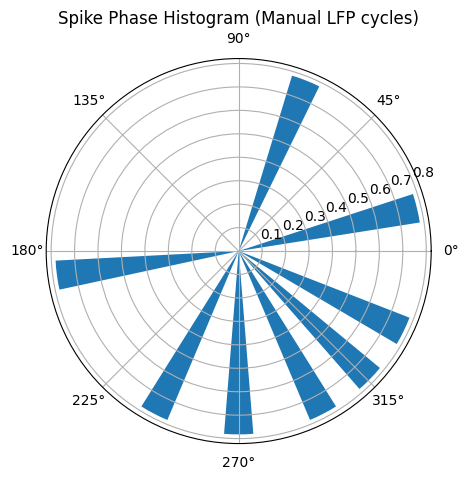

In [101]:
# 1. Detect threshold crossings (downward from >3 to <0)
# spike_indices = []
# for j in range(len(z) - 1):
#     z1 = z[j]
#     z2 = z[j + 1]
#     if z1 > 3 and z2 < 0:
#         spike_indices.append(j - 1)  # mimic MATLAB's j-1

from scipy.signal import find_peaks

peaks, _ = find_peaks(df_lfp.qe75, distance=distance)
t_peak = df_lfp.t[peaks]
print(t_peak)
# 2. Compute phase for each spike relative to LFP cycle
spike_phases = []
for x in t_peak:
    for k in range(len(tm)-1):
        lo = tm[k]
        hi = tm[k + 1]
        if lo < x < hi:
            period = hi - lo
            phase = 360 * (x - lo) / period
            spike_phases.append(phase)
            break

print(spike_phases)
# 3. Output or plot
spike_phases = np.array(spike_phases)
print("Spike phases (degrees):", spike_phases)

if len(spike_phases)>0:
    complex_phase = np.exp(1j*np.radians(spike_phases))
    vec = np.mean(complex_phase)
    MVL = np.abs(vec)
    preferred_phase = np.degrees(np.angle(vec))

print(MVL)
print(preferred_phase)

# Optional: Polar histogram
plt.figure(figsize=(5, 5))
plt.subplot(111, polar=True)
plt.hist(np.radians(spike_phases), bins=36, density=True)
plt.title("Spike Phase Histogram (Manual LFP cycles)")
plt.show()


In [82]:
peaks

array([  62,  384,  706, 1028, 1348, 1670, 1992, 2312])

In [ ]:
peaks, _ = find_peaks(df_lfp.qe75)
peaks

array([ 278,  521,  739, 1006, 1300, 1601, 1899, 2172, 2383])

In [ ]:
find_peaks(lfp_phase)

(array([ 209,  539,  843, 1161, 1485, 1796, 2147, 2375, 2484, 2486, 2488,
        2490, 2492, 2494, 2496]),
 {})

In [92]:
import pandas as pd

# --- Get LFP cycle boundaries ---
tm = df_lfp['t'].values[P_idx]  # P_idx = indices of LFP se peaks
se_cycle_labels = range(len(tm) - 1)

# --- Function to map each spike time to its LFP cycle ---
def assign_cycle(spike_times, tm):
    assigned = []
    for t in spike_times:
        for i in range(len(tm) - 1):
            if tm[i] < t < tm[i + 1]:
                assigned.append((t, i))  # (time, se_cycle_index)
                break
    return assigned

# --- Get spike times for each population ---
spikes_qe = df_lfp['t'].values[find_peaks(df_lfp.qe75.values, distance=distance)[0]]
spikes_qi = df_lfp['t'].values[find_peaks(df_lfp.qi75.values, distance=distance)[0]]
spikes_qs = df_lfp['t'].values[find_peaks(df_lfp.qs75.values, distance=distance)[0]]

# --- Assign each spike to its LFP cycle ---
qe_assigned = assign_cycle(spikes_qe, tm)
qi_assigned = assign_cycle(spikes_qi, tm)
qs_assigned = assign_cycle(spikes_qs, tm)

# --- Group spikes by se_cycle_index ---
from collections import defaultdict

grouped = defaultdict(lambda: {"qe75": [], "qi75": [], "qs75": [], "se_start": None, "se_end": None})

for t, idx in qe_assigned:
    grouped[idx]["qe75"].append(t)
for t, idx in qi_assigned:
    grouped[idx]["qi75"].append(t)
for t, idx in qs_assigned:
    grouped[idx]["qs75"].append(t)
for idx in grouped:
    grouped[idx]["se_start"] = tm[idx]
    grouped[idx]["se_end"] = tm[idx + 1]

# --- Flatten to rows with repeated entries if needed ---
table_rows = []
for idx in sorted(grouped.keys()):
    row = grouped[idx]
    max_len = max(len(row["qe75"]), len(row["qi75"]), len(row["qs75"]), 1)
    for i in range(max_len):
        table_rows.append({
            "se_cycle": idx,
            "se_start": row["se_start"],
            "se_end": row["se_end"],
            "qe75_peak_time": row["qe75"][i] if i < len(row["qe75"]) else None,
            "qi75_peak_time": row["qi75"][i] if i < len(row["qi75"]) else None,
            "qs75_peak_time": row["qs75"][i] if i < len(row["qs75"]) else None
        })

# --- Create DataFrame ---
df_spike_table = pd.DataFrame(table_rows)
display(df_spike_table)


,se_cycle,se_start,se_end,qe75_peak_time,qi75_peak_time,qs75_peak_time
0,0,157.60001,221.39999,205.60001,169.39999,162.39999
1,1,221.39999,285.39999,254.20000,234.80000,226.80000
2,2,285.39999,349.60001,297.79999,299.39999,291.20001
3,3,349.60001,413.79999,351.20001,364.00000,355.60001
4,3,349.60001,413.79999,410.00000,NaN,NaN
5,4,413.79999,477.60001,470.20001,428.20001,419.60001
6,5,477.60001,541.59998,529.79999,493.00000,484.00000
7,6,541.59998,606.00000,584.40002,557.59998,548.40002


In [104]:
from scipy.signal import find_peaks

# --- Parameters ---
num_neurons = 400
population_prefixes = ['qe', 'qi', 'qs']
mvl_results = {}

# --- Loop through all populations and neurons ---
for pop in population_prefixes:
    mvls = []
    for i in range(num_neurons):
        signal = df_lfp[f"{pop}{i}"].values
        peaks, _ = find_peaks(signal, distance=distance)
        if len(peaks) == 0:
            continue
        t_peaks = df_lfp['t'].values[peaks]

        # Compute phase of each spike w.r.t. se-cycle from tm
        spike_phases = []
        for x in t_peaks:
            for k in range(len(tm) - 1):
                lo = tm[k]
                hi = tm[k + 1]
                if lo < x < hi:
                    period = hi - lo
                    phase = 360 * (x - lo) / period
                    spike_phases.append(phase)
                    break

        if len(spike_phases) == 0:
            continue

        complex_phase = np.exp(1j * np.radians(spike_phases))
        vec = np.mean(complex_phase)
        mvl = np.abs(vec)
        mvls.append(mvl)

    # Store results for this population
    mvls = np.array(mvls)
    mvl_results[pop] = {
        'individual_mvls': mvls,
        'mean_mvl': np.mean(mvls) if len(mvls) > 0 else None,
        'n_neurons_used': len(mvls)
    }

# --- Display summary ---
for pop in population_prefixes:
    mean_mvl = mvl_results[pop]['mean_mvl']
    n = mvl_results[pop]['n_neurons_used']
    print(f"{pop}: Average MVL = {mean_mvl:.4f} across {n} neurons")

qe: Average MVL = 0.7997 across 400 neurons
qi: Average MVL = 0.9783 across 400 neurons
qs: Average MVL = 0.9858 across 400 neurons


In [102]:
# from scipy.signal import find_peaks

# # Get LFP phase with Hilbert transform
# # We can simply use this one as well
# # lfp_signal = df_lfp["se"].values
# # lfp_signal -= np.mean(lfp_signal)  # <- Critical step!

# # lfp_phase = np.angle(hilbert(lfp_signal))
# # lfp_deg = np.degrees(lfp_phase)
# from scipy.signal import butter, filtfilt

# def bandpass(signal, low, high, fs, order=4):
#     nyq = 0.5 * fs
#     b, a = butter(order, [low / nyq, high / nyq], btype='band')
#     return filtfilt(b, a, signal)

# # Optional bandpass before Hilbert
# lfp_signal_filtered = bandpass(lfp_signal, low=10, high=80, fs=5000)
# lfp_phase = np.angle(hilbert(lfp_signal_filtered - np.mean(lfp_signal_filtered)))

# # def compute_phase_locking(signal, lfp_phase, distance=10):
# #     peaks, _ = find_peaks(signal, distance=distance)
# #     phases = lfp_phase[peaks]
# #     if len(phases) == 0:
# #         return None, None, phases
# #     mean_vector = np.mean(np.exp(1j * phases))
# #     return np.angle(mean_vector), np.abs(mean_vector), phases

# def compute_phase_locking(spike_train, lfp_phase, threshold=None):
#     if threshold is None:
#         threshold = np.mean(spike_train) + np.std(spike_train)  # reasonable cutoff

#     spike_indices = spike_train > threshold
#     phases = lfp_phase[spike_indices]

#     if len(phases) == 0:
#         return None, None, phases

#     mean_vector = np.mean(np.exp(1j * phases))
#     preferred_phase = np.angle(mean_vector)
#     mvl = np.abs(mean_vector)
#     return preferred_phase, mvl, phases



# # Compute for qe75, qi75, qs75
# results0 = {}
# for name in ["qe75", "qi75", "qs75"]:
#     spike_train = df_lfp[name].values
#     phase, mvl, phases = compute_phase_locking(spike_train, lfp_phase)
#     if phase is not None:
#         print(f"{name}: Preferred phase = {np.mod(np.degrees(phase),360):.2f}°, MVL = {mvl:.3f}")
#     else:
#         print(f"{name}: No spikes detected")
#     results0[name] = {
#         "preferred_phase_deg": np.mod(np.degrees(phase),360) if phase is not None else None,
#         "mvl": mvl,
#         "phases": phases
#     }

# print(results0)
# df_result0 = pd.DataFrame(results0)

These results align well with what you cited from the CAMINOS paper:

PV cells (qi75): Strongest and earliest locking, crucial for frequency & stability

SOM cells (qs75): Later phase, responsible for amplitude modulation

E cells (qe75): More diffuse locking, modulated by both inhibitory populations

In [61]:
# Analyze all neurons
results = []

for pop in ['qe', 'qi', 'qs']:
    for i in range(400):
        name = f"{pop}{i}"
        spikes = df_lfp[name].values
        phase, mvl, phases = compute_phase_locking(spikes, lfp_phase)
        results.append({
            "neuron": name,
            "population": pop,
            "index": i,
            "preferred_phase_deg": np.degrees(phase) if phase is not None else None,
            "mvl": mvl
        })

# Convert to DataFrame
df_results = pd.DataFrame(results1)

# Save or display
print(df_results.head())
# Optional: df_results.to_csv("phase_locking_results.csv", index=False)

  neuron population  index  preferred_phase_deg       mvl
0    qe0         qe      0           -87.287310  0.415921
1    qe1         qe      1           101.795748  0.500226
2    qe2         qe      2           -60.886341  0.954497
3    qe3         qe      3           -47.234791  0.973408
4    qe4         qe      4           166.884407  0.278095


In [62]:
from scipy.stats import circmean

# Filter valid data
valid_df = df_results.dropna(subset=["preferred_phase_deg", "mvl"])

# Function to compute circular mean (phase in radians → degrees)
def population_phase_summary(group):
    mean_phase = circmean(group["preferred_phase_deg"], high=180, low=-180)
    mean_mvl = group["mvl"].mean()
    return pd.Series({
        "mean_preferred_phase_deg": mean_phase,
        "mean_mvl": mean_mvl,
        "n_neurons": len(group)
    })

summary_df = valid_df.groupby("population").apply(population_phase_summary).reset_index()
print(summary_df)


  population  mean_preferred_phase_deg  mean_mvl  n_neurons
0         qe                -43.534478  0.751681      400.0
1         qi                144.328747  0.496603      400.0
2         qs                178.610358  0.658022      400.0


/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_32401/220029830.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = valid_df.groupby("population").apply(population_phase_summary).reset_index()


/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/2629322378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["cos_phase"] = np.cos(np.radians(valid_df["preferred_phase_deg"]))
/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/2629322378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["sin_phase"] = np.sin(np.radians(valid_df["preferred_phase_deg"]))
/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/2629322378.py:13: SettingWithCopyWarning: 

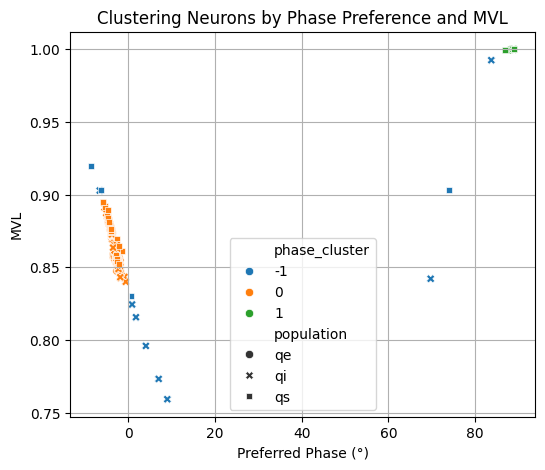

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Convert polar to Cartesian
valid_df["cos_phase"] = np.cos(np.radians(valid_df["preferred_phase_deg"]))
valid_df["sin_phase"] = np.sin(np.radians(valid_df["preferred_phase_deg"]))

X_phase = valid_df[["cos_phase", "sin_phase", "mvl"]].values
X_scaled = StandardScaler().fit_transform(X_phase)

# Cluster using DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)
valid_df["phase_cluster"] = db.labels_

# Plot clusters
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=valid_df, 
    x="preferred_phase_deg", 
    y="mvl", 
    hue="phase_cluster", 
    style="population",
    palette="tab10"
)
plt.title("Clustering Neurons by Phase Preference and MVL")
plt.xlabel("Preferred Phase (°)")
plt.ylabel("MVL")
plt.grid(True)
plt.show()

/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/1848496695.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=valid_df, x="population", y="mvl", palette="muted")


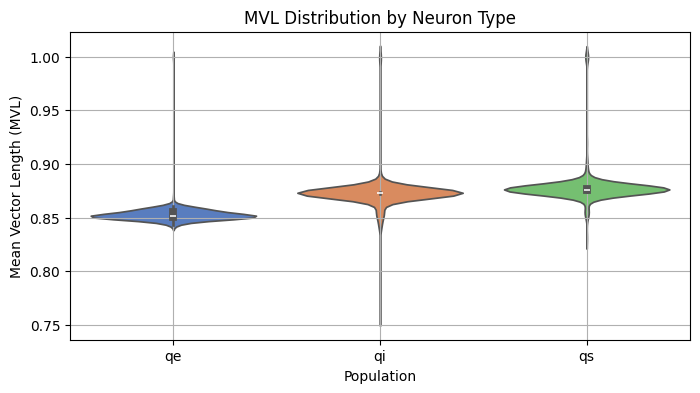

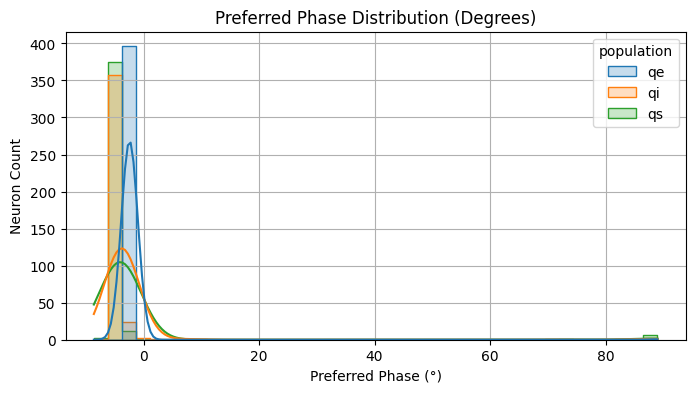

In [8]:
import seaborn as sns

# Filter valid entries
valid_df = df_results.dropna(subset=["preferred_phase_deg", "mvl"])

# Plot MVL distribution by population
plt.figure(figsize=(8, 4))
sns.violinplot(data=valid_df, x="population", y="mvl", palette="muted")
plt.title("MVL Distribution by Neuron Type")
plt.ylabel("Mean Vector Length (MVL)")
plt.xlabel("Population")
plt.grid(True)
plt.show()

# Plot preferred phase distributions
plt.figure(figsize=(8, 4))
sns.histplot(data=valid_df, x="preferred_phase_deg", hue="population", bins=40, kde=True, element="step")
plt.title("Preferred Phase Distribution (Degrees)")
plt.xlabel("Preferred Phase (°)")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.show()


/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/174144671.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["cluster"] = kmeans.fit_predict(X)


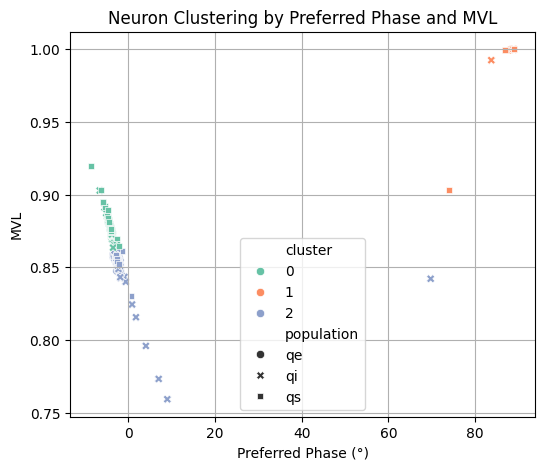

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare features
X = valid_df[["preferred_phase_deg", "mvl"]].values
X = StandardScaler().fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
valid_df["cluster"] = kmeans.fit_predict(X)

# Visualize
plt.figure(figsize=(6, 5))
sns.scatterplot(data=valid_df, x="preferred_phase_deg", y="mvl", hue="cluster", style="population", palette="Set2")
plt.title("Neuron Clustering by Preferred Phase and MVL")
plt.xlabel("Preferred Phase (°)")
plt.ylabel("MVL")
plt.grid(True)
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Encode population
pop_map = {'qe': 0, 'qi': 1, 'qs': 2}
valid_df["pop_label"] = valid_df["population"].map(pop_map)

X = valid_df[["preferred_phase_deg", "mvl"]]
y = valid_df["pop_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       119
           1       0.94      0.87      0.90       119
           2       0.90      0.93      0.91       119

    accuracy                           0.92       357
   macro avg       0.92      0.92      0.92       357
weighted avg       0.92      0.92      0.92       357

Confusion Matrix:
 [[115   2   2]
 [  5 103  11]
 [  3   5 111]]


/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_9265/2265233348.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["pop_label"] = valid_df["population"].map(pop_map)


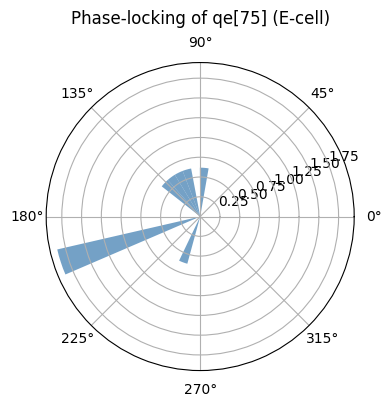

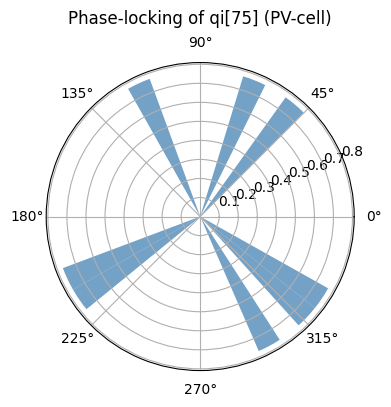

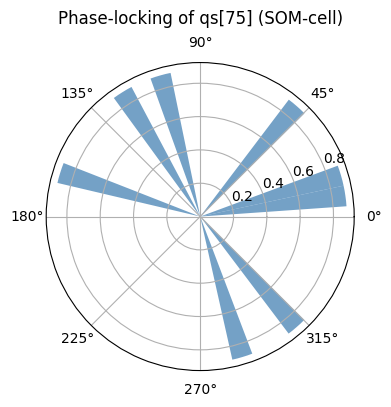

In [ ]:
# def bandpass_filter(data, fs, lowcut=4, highcut=10, order=4):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     return filtfilt(b, a, data)

# fs = 1 / 0.04  # = 25 Hz
# lfp_beta = bandpass_filter(lfp_signal, fs)

# # ----------------------------
# # 3. Phase Extraction via Hilbert Transform
# # ----------------------------

# analytic_signal = hilbert(lfp_beta)
# lfp_phase = np.angle(analytic_signal)  # Phase in radians (–π to π)

# # ----------------------------
# # 4. Detect Spike Times (Threshold Crossing at 0)
# # ----------------------------

# def detect_spikes(voltage, threshold=0.0):
#     return np.where((voltage[:-1] < threshold) & (voltage[1:] >= threshold))[0]

# qe_spikes = detect_spikes(qe75)
# qi_spikes = detect_spikes(qi75)
# qs_spikes = detect_spikes(qs75)

# # ----------------------------
# # 5. Extract LFP Phase at Spike Times
# # ----------------------------

# qe_phases = lfp_phase[qe_spikes]
# qi_phases = lfp_phase[qi_spikes]
# qs_phases = lfp_phase[qs_spikes]

# # ----------------------------
# # 6. Plot Polar Phase Histograms
# # ----------------------------

# def plot_phase_histogram(phases, neuron_label):
#     plt.figure(figsize=(4, 4))
#     ax = plt.subplot(111, polar=True)
#     ax.hist(phases, bins=30, density=True, alpha=0.75, color='steelblue')
#     ax.set_title(f"Phase-locking of {neuron_label}", va='bottom')
#     plt.show()

# plot_phase_histogram(qe_phases, "qe[75] (E-cell)")
# plot_phase_histogram(qi_phases, "qi[75] (PV-cell)")
# plot_phase_histogram(qs_phases, "qs[75] (SOM-cell)")